# Modelling with Tensorflow

This implementation presents an example of execution environment supported by machine type and GPUs. This implementation demonstrates on how the model can be trained directly within runtime of environment. The model is saved and transferred to deployment as a Endpoint for online predictions. 
The model training is carried out with Tensorflow (Keras) and demonstartes a neural network approach to logistic regression. The training data is read by Tensorflow I/O.


## Setting Up

In [1]:
REGION = 'us-central1'
PROJECT_ID='mlopstqc'
DATANAME = 'leaktest'
IDENTIFIER = '7'

# Resources
DEPLOY_COMPUTE = 'n1-standard-2'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'

# Model Training
VAR_TARGET = 'TestPressureMbar'
VAR_OMIT = 'transaction_id'
EPOCHS = 10
BATCH_SIZE = 100

In [2]:
from google.cloud import bigquery

from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
import tensorflow as tf

from google.cloud import aiplatform
from datetime import datetime
import os

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

2022-04-26 11:33:33.486653: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2022-04-26 11:33:33.487097: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

In [4]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{IDENTIFIER}"
DIR = f"temp/{IDENTIFIER}"

In [5]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Training the data

Data is sourced through a data warehouse. Rather than as an instance of the data as a data frame we leverage a more scalable way to accomodate very large training sets. Tensorflow I/O reads batches of training data in paralele during model training.

### Data Scehma
Retrieving column information about the training data. 

In [6]:
query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
schema = bigquery.query(query).to_dataframe()
schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position
0,mlopstqc,leaktest,leaktest_prepped,TestVolumeLitre,1,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
1,mlopstqc,leaktest,leaktest_prepped,AlarmDiffPressure,2,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN
2,mlopstqc,leaktest,leaktest_prepped,TestPressureMbar,3,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN
3,mlopstqc,leaktest,leaktest_prepped,transaction_id,4,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN
4,mlopstqc,leaktest,leaktest_prepped,splits,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,NaN


### Determining the number of classes
<code>VAR_TARGET</code> is used to classify the data into labels.

In [7]:
nclasses = bigquery.query(query = f'SELECT DISTINCT {VAR_TARGET} FROM {DATANAME}.{DATANAME}_prepped WHERE {VAR_TARGET} is not null').to_dataframe()
nclasses

,TestPressureMbar
0,12800
1,19200
2,25600
3,32000
4,38400
...,...
196,23800
197,30200
198,36600
199,43000


In [8]:
nclasses = nclasses.shape[0]
nclasses

201

## Selecting Columns and Data Types

Preparing tensorflow model inputs by omiting unused columns, and creating list of <code>selected_fields</code> from training source. The data types are defined, and remapped to desired precision. 

In [9]:
# Make a list of columns to omit
OMIT = VAR_OMIT.split() + ['splits']

# use schema to prepare a list of columns to read from BigQuery
selected_fields = schema[~schema.column_name.isin(OMIT)].column_name.tolist()

# all the columns in this data source are either float64 or int64
output_types = [dtypes.float64 if x=='FLOAT64' else dtypes.int64 for x in schema[~schema.column_name.isin(OMIT)].data_type.tolist()]


## Reading Data from Data Warehouse source using Tensorflow I/O

### Dividing the inputs into features and target
We define a function that remaps input data from the source into features and target. The target is a on-hot encoding for multi-class classification and for binary classification.


In [10]:
def transTable(row_dict):
    target = row_dict.pop(VAR_TARGET)
    target = tf.one_hot(tf.cast(target,tf.int64), nclasses)
    target = tf.cast(target, tf.float32)
    return(row_dict, target)

### Setting the Tensorflow I/O  to read  batches of data from Data Warehouse Source



In [11]:
def bq_reader(split):
    reader = BigQueryClient()

    training = reader.read_session(
        parent = f"projects/{PROJECT_ID}",
        project_id = PROJECT_ID,
        table_id = f"{DATANAME}_prepped",
        dataset_id = DATANAME,
        selected_fields = selected_fields,
        output_types = output_types,
        row_restriction = f"splits='{split}'",
        requested_streams = 3
    )
    
    return training

In [12]:
train = bq_reader('TRAIN').parallel_read_rows().prefetch(1).map(transTable).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)
validate = bq_reader('VALIDATE').parallel_read_rows().prefetch(1).map(transTable).batch(BATCH_SIZE)
test = bq_reader('TEST').parallel_read_rows().prefetch(1).map(transTable).batch(BATCH_SIZE)

2022-04-26 11:34:42.400266: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299995000 Hz
2022-04-26 11:34:42.400603: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c635917d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-26 11:34:42.400629: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-26 11:34:42.403265: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
# for features, target in train.take(1):
#     print('features:\n',list(features.keys()))
#     print('\ntarget:\n',target[0:10])

In [13]:
# Logistic Regression

# model input definitions
feature_columns = {header: tf.feature_column.numeric_column(header) for header in selected_fields if header != VAR_TARGET}
feature_layer_inputs = {header: tf.keras.layers.Input(shape = (1,), name = header) for header in selected_fields if header != VAR_TARGET}

# feature columns to a Dense Feature Layer
feature_layer_outputs = tf.keras.layers.DenseFeatures(feature_columns.values())(feature_layer_inputs)

# batch normalization then Dense with softmax activation to nclasses
layers = tf.keras.layers.BatchNormalization()(feature_layer_outputs)
layers = tf.keras.layers.Dense(nclasses, activation = tf.nn.softmax)(layers)

# the model
model = tf.keras.Model(
    inputs = feature_layer_inputs,
    outputs = layers
)
opt = tf.keras.optimizers.SGD() #SGD or Adam
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer = opt,
    loss = loss,
    metrics = ['accuracy', tf.keras.metrics.AUC(curve='PR')]
)

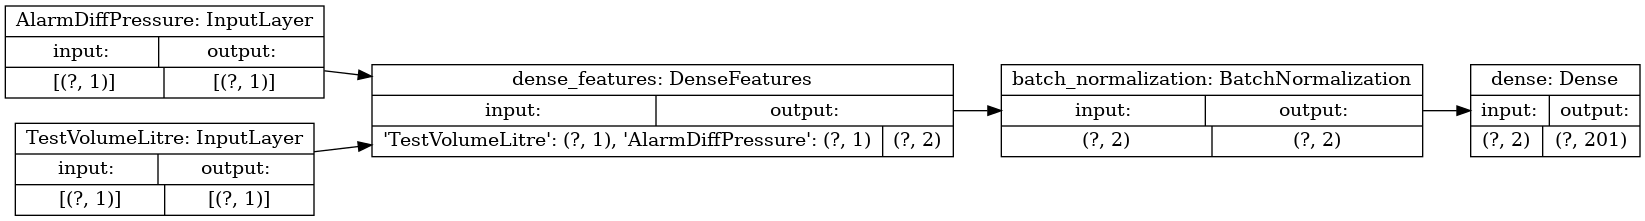

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')


In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
AlarmDiffPressure (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
TestVolumeLitre (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_features (DenseFeatures)  (None, 2)            0           AlarmDiffPressure[0][0]          
                                                                 TestVolumeLitre[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2)            8           dense_features[0][0]  

In [16]:
# setup tensorboard logs and train
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(DIR, "logs", datetime.now().strftime("%Y%m%d-%H%M%S")), histogram_freq=1)
history = model.fit(train, epochs = EPOCHS, callbacks = [tensorboard_callback], validation_data = validate)                                                                                                                                                                


2022-04-26 11:35:06.955386: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Epoch 1/10
      1/Unknown - 0s 237us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
      2/Unknown - 0s 99ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00 

2022-04-26 11:35:08.698845: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-26 11:35:08.841911: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: temp/7/logs/20220426-113506/train/plugins/profile/2022_04_26_11_35_08
2022-04-26 11:35:08.857675: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to temp/7/logs/20220426-113506/train/plugins/profile/2022_04_26_11_35_08/tensorflow-tqcmlops.trace.json.gz
2022-04-26 11:35:08.879341: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: temp/7/logs/20220426-113506/train/plugins/profile/2022_04_26_11_35_08
2022-04-26 11:35:08.881564: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to temp/7/logs/20220426-113506/train/plugins/profile/2022_04_26_11_35_08/tensorflow-tqcmlops.memory_profile.json.gz
2022-04-26 11:35:08.883420: I tensorflow/pyt

266/266 [==============================] - 29s 108ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/10
266/266 [==============================] - 28s 107ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/10
266/266 [==============================] - 29s 110ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 4/10
266/266 [==============================] - 28s 107ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 5/10
266/266 [==============================] - 29s 107ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 

In [17]:
history.history['loss'][-1]

0.0

In [18]:
loss, accuracy, auc = model.evaluate(test)

34/34 [==============================] - 3s 82ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00


In [19]:
loss, accuracy, auc = model.evaluate(validate)

34/34 [==============================] - 3s 77ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00


In [20]:
loss, accuracy, auc = model.evaluate(train)

266/266 [==============================] - 23s 87ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - auc: 0.0000e+00


In [21]:
model.predict(test.take(1))[0]

array([0.00522721, 0.00507356, 0.00520584, 0.00511371, 0.00556389,
       0.00496191, 0.00501617, 0.005401  , 0.00547496, 0.00485341,
       0.00433205, 0.00485551, 0.00462134, 0.00433915, 0.00487604,
       0.00501349, 0.0047436 , 0.00471795, 0.00514931, 0.00448117,
       0.00496489, 0.00432876, 0.00452599, 0.00526601, 0.00476536,
       0.0046434 , 0.00455644, 0.0055368 , 0.00519737, 0.00563021,
       0.00514558, 0.0052565 , 0.00454907, 0.0051782 , 0.00485389,
       0.00526117, 0.00494098, 0.00464854, 0.00476547, 0.00549748,
       0.00506927, 0.00456959, 0.00483761, 0.00485287, 0.00493436,
       0.00510068, 0.00555724, 0.00480719, 0.0049443 , 0.0047423 ,
       0.00491435, 0.00526097, 0.00517786, 0.0045667 , 0.00504001,
       0.00517804, 0.00523952, 0.00509554, 0.00568576, 0.00486719,
       0.00486643, 0.00546043, 0.00520131, 0.00476808, 0.00509487,
       0.00518969, 0.00488877, 0.00538765, 0.0044329 , 0.00466103,
       0.00527066, 0.00446926, 0.00442298, 0.00463186, 0.00479

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir $DIR/logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/opt/conda/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/main.py", line 65, in run_main
    default.get_plugins(),
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/default.py", line 113, in get_plugins
    return get_static_plugins() + get_dynamic_plugins()
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/default.py", line 151, in get_dynamic_plugins
    "tensorboard_plugins"
  File "/opt/conda/lib/python3.7/site-packages/tensorboard/default.py", line 150, in <listcomp>
    for entry_point in pkg_resources.iter_entry_points(
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2464, in load
    self.require(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2487, in require
    items = working_set.resolve

In [24]:
model.save(URI)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-04-26 12:50:52.324461: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://mlopstqc/leaktest/models/7/assets
INFO:tensorflow:Assets written to: gs://mlopstqc/leaktest/models/7/assets


In [25]:
model = aiplatform.Model.upload(
    display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    serving_container_image_uri = DEPLOY_IMAGE,
    artifact_uri = URI,
    labels = {'notebook':f'{IDENTIFIER}'}
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/969346734638/locations/us-central1/models/2255973559824285696/operations/8661819081676029952
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/969346734638/locations/us-central1/models/2255973559824285696
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/969346734638/locations/us-central1/models/2255973559824285696')


In [27]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{IDENTIFIER}'}
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/969346734638/locations/us-central1/endpoints/263152714945396736/operations/3366711819795169280
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/969346734638/locations/us-central1/endpoints/263152714945396736
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/969346734638/locations/us-central1/endpoints/263152714945396736')


In [28]:
endpoint.display_name

'7_leaktest_20220426113339'

In [30]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

INFO:google.cloud.aiplatform.models:Deploying Model projects/969346734638/locations/us-central1/models/2255973559824285696 to Endpoint : projects/969346734638/locations/us-central1/endpoints/263152714945396736
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/969346734638/locations/us-central1/endpoints/263152714945396736/operations/1609182065213833216
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/969346734638/locations/us-central1/endpoints/263152714945396736


In [31]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()


In [32]:
pred.head(4)

,TestVolumeLitre,AlarmDiffPressure,TestPressureMbar,transaction_id,splits
0,0.2,500,12800,68cfe17b-33f6-4240-9254-d77514feb083,TEST
1,10.0,320,12800,e6cc26be-a050-4c91-99cf-52c2dcea0924,TEST
2,0.1,320,12800,b5e82b71-f62a-400a-9cf1-f551b2b57bf9,TEST
3,0.1,320,12800,d2f9cc2b-4aed-4734-a723-17b44020021b,TEST


In [33]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
#newob

In [34]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

In [35]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[[0.00522721186, 0.00507355947, 0.00520583754, 0.00511370599, 0.00556389289, 0.00496191252, 0.00501616718, 0.00540099479, 0.00547495717, 0.00485341297, 0.00433204928, 0.00485550892, 0.00462133903, 0.00433915, 0.00487604085, 0.0050134859, 0.00474360166, 0.00471795, 0.00514931185, 0.00448117033, 0.0049648853, 0.00432876218, 0.0045259851, 0.00526601402, 0.00476536108, 0.00464340113, 0.00455644261, 0.00553679559, 0.00519737415, 0.0056302133, 0.00514557539, 0.00525650335, 0.0045490656, 0.00517820101, 0.00485389121, 0.00526117114, 0.00494097825, 0.00464853877, 0.00476547517, 0.00549747748, 0.00506927306, 0.00456959475, 0.00483761495, 0.0048528742, 0.00493436167, 0.00510068471, 0.00555723766, 0.00480718771, 0.00494429516, 0.00474229874, 0.00491434569, 0.00526097137, 0.00517785782, 0.00456670485, 0.00504001, 0.00517804315, 0.00523951603, 0.00509553822, 0.00568575738, 0.00486719236, 0.0048664324, 0.00546042621, 0.00520131411, 0.00476808427, 0.00509487186, 0.00518969353, 0

In [36]:
prediction.predictions[0]

[0.00522721186,
 0.00507355947,
 0.00520583754,
 0.00511370599,
 0.00556389289,
 0.00496191252,
 0.00501616718,
 0.00540099479,
 0.00547495717,
 0.00485341297,
 0.00433204928,
 0.00485550892,
 0.00462133903,
 0.00433915,
 0.00487604085,
 0.0050134859,
 0.00474360166,
 0.00471795,
 0.00514931185,
 0.00448117033,
 0.0049648853,
 0.00432876218,
 0.0045259851,
 0.00526601402,
 0.00476536108,
 0.00464340113,
 0.00455644261,
 0.00553679559,
 0.00519737415,
 0.0056302133,
 0.00514557539,
 0.00525650335,
 0.0045490656,
 0.00517820101,
 0.00485389121,
 0.00526117114,
 0.00494097825,
 0.00464853877,
 0.00476547517,
 0.00549747748,
 0.00506927306,
 0.00456959475,
 0.00483761495,
 0.0048528742,
 0.00493436167,
 0.00510068471,
 0.00555723766,
 0.00480718771,
 0.00494429516,
 0.00474229874,
 0.00491434569,
 0.00526097137,
 0.00517785782,
 0.00456670485,
 0.00504001,
 0.00517804315,
 0.00523951603,
 0.00509553822,
 0.00568575738,
 0.00486719236,
 0.0048664324,
 0.00546042621,
 0.00520131411,
 0.00476

In [37]:
np.argmax(prediction.predictions[0])

105

In [38]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [39]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

E0426 13:09:06.830921532   23460 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{
  "predictions": [
    [
      0.00522721186,
      0.00507355947,
      0.00520583754,
      0.00511370599,
      0.00556389289,
      0.00496191252,
      0.00501616718,
      0.00540099479,
      0.00547495717,
      0.00485341297,
      0.00433204928,
      0.00485550892,
      0.00462133903,
      0.00433915,
      0.00487604085,
      0.0050134859,
      0.00474360166,
      0.00471795,
      0.00514931185,
      0.00448117033,
      0.0049648853,
      0.00432876218,
      0.0045259851,
      0.00526601402,
      0.00476536108,
      0.00464340113,
      0.00455644261,
      0.00553679559,
      0.00519737415,
      0.0056302133,
      0.00514557539,
      0.00525650335,
      0.0045490656,
      0.00517820101,
      0.00485389121,
      0.00526117114,
      0.00494097825,
      0.00464853877,
      0.00476547517,
      0.00549747748,
      0.00506927306,
      0.00456959475,
      0.00483761495,
      0.0048528742,
      0.00493436167,
      0.00510068471,
      0.00555723766

In [40]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json


E0426 13:09:18.559084816   23460 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[[0.00522721186, 0.00507355947, 0.00520583754, 0.00511370599, 0.00556389289, 0.00496191252, 0.00501616718, 0.00540099479, 0.00547495717, 0.00485341297, 0.00433204928, 0.00485550892, 0.00462133903, 0.00433915, 0.00487604085, 0.0050134859, 0.00474360166, 0.00471795, 0.00514931185, 0.00448117033, 0.0049648853, 0.00432876218, 0.0045259851, 0.00526601402, 0.00476536108, 0.00464340113, 0.00455644261, 0.00553679559, 0.00519737415, 0.0056302133, 0.00514557539, 0.00525650335, 0.0045490656, 0.00517820101, 0.00485389121, 0.00526117114, 0.00494097825, 0.00464853877, 0.00476547517, 0.00549747748, 0.00506927306, 0.00456959475, 0.00483761495, 0.0048528742, 0.00493436167, 0.00510068471, 0.00555723766, 0.00480718771, 0.00494429516, 0.00474229874, 0.00491434569, 0.00526097137, 0.00517785782, 0.00456670485, 0.00504001, 0.00517804315, 0.00523951603, 0.00509553822, 0.00568575738, 0.00486719236, 0.0048664324, 0.00546042621, 0.0052013